# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

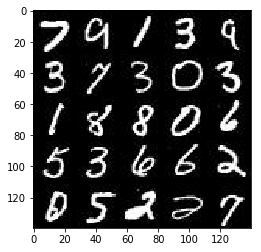

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

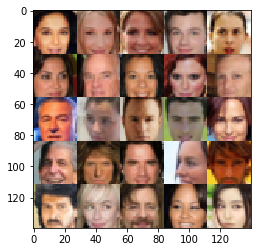

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape = (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def leaky_ReLU(tensor, alpha=0.2):
    return tf.maximum(alpha * tensor, tensor)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = leaky_ReLU(conv1, alpha)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = leaky_ReLU(conv2, alpha)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=1, padding='same',
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = leaky_ReLU(conv3, alpha)
        # 7x7x256

        flat = tf.contrib.layers.flatten(conv3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    with tf.variable_scope('generator', reuse = (not is_train)):
        fc = tf.layers.dense(z,  7 * 7 * 512)
                           
        reshaped = tf.reshape(fc, (-1, 7, 7, 512))
        normalized = tf.layers.batch_normalization(reshaped, training=is_train)
        normalized = tf.maximum(alpha * normalized, normalized)
        # 7x7x512 now
        
        deconv1 = tf.layers.conv2d_transpose(normalized, 256, 5, strides=2, padding='same')
        deconv1 = tf.layers.batch_normalization(deconv1, training=is_train)
        deconv1 = tf.maximum(alpha * deconv1, deconv1)
        # 7x7x256 now
        
        deconv2 = tf.layers.conv2d_transpose(deconv1, 128, 5, strides=2, padding='same')
        deconv2 = tf.layers.batch_normalization(deconv2, training = is_train)
        deconv2 = tf.maximum(alpha * deconv2, deconv2)
        # 14x14x128 now
        
        deconv3 = tf.layers.conv2d_transpose(deconv2, 64, 5, strides=1, padding='same')
        deconv3 = tf.layers.batch_normalization(deconv3, training = is_train)
        deconv3 = tf.maximum(alpha * deconv3, deconv3)
        # 14x14x64 now
        
        # Output layer
        out = tf.layers.conv2d_transpose(deconv3, out_channel_dim, 3, strides=1,
                                         padding='same', activation=tf.tanh)
        # 28x28xout_channel_dim now
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,labels = tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * 0.9))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(
        d_loss, var_list=d_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, width, height, n_channels = data_shape
    input_real, input_z, learning_rate_ph = model_inputs(width, height, n_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, n_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                               learning_rate_ph: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z,
                                               learning_rate_ph: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, n_channels, data_image_mode)
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8409... Generator Loss: 0.4664
Epoch 1/2... Discriminator Loss: 0.3901... Generator Loss: 4.9524
Epoch 1/2... Discriminator Loss: 0.3987... Generator Loss: 2.8198
Epoch 1/2... Discriminator Loss: 0.3668... Generator Loss: 3.8553
Epoch 1/2... Discriminator Loss: 0.3918... Generator Loss: 3.7484
Epoch 1/2... Discriminator Loss: 1.6341... Generator Loss: 0.6102
Epoch 1/2... Discriminator Loss: 1.2692... Generator Loss: 0.9613
Epoch 1/2... Discriminator Loss: 1.1216... Generator Loss: 1.1562
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 1.2099
Epoch 1/2... Discriminator Loss: 1.6767... Generator Loss: 1.3946


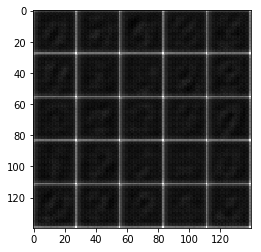

Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.6605
Epoch 1/2... Discriminator Loss: 1.3884... Generator Loss: 1.1319
Epoch 1/2... Discriminator Loss: 1.2795... Generator Loss: 0.9564
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 0.8880
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 1.2032
Epoch 1/2... Discriminator Loss: 1.4711... Generator Loss: 1.6905
Epoch 1/2... Discriminator Loss: 1.2511... Generator Loss: 1.3437
Epoch 1/2... Discriminator Loss: 1.1916... Generator Loss: 1.1573
Epoch 1/2... Discriminator Loss: 1.3463... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.8811


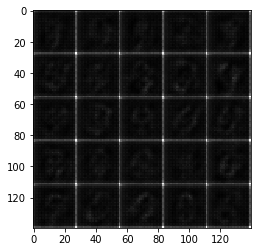

Epoch 1/2... Discriminator Loss: 1.2779... Generator Loss: 0.6169
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 1.5843
Epoch 1/2... Discriminator Loss: 1.1015... Generator Loss: 0.8656
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 1.4436
Epoch 1/2... Discriminator Loss: 1.2302... Generator Loss: 0.6406
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 0.9172
Epoch 1/2... Discriminator Loss: 1.3751... Generator Loss: 2.2673
Epoch 1/2... Discriminator Loss: 1.0128... Generator Loss: 1.1671
Epoch 1/2... Discriminator Loss: 1.1223... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 1.5766


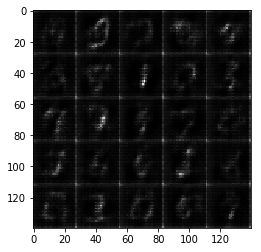

Epoch 1/2... Discriminator Loss: 1.4081... Generator Loss: 0.5399
Epoch 1/2... Discriminator Loss: 1.1122... Generator Loss: 0.8294
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.8027
Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 0.7687
Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 1.2011
Epoch 1/2... Discriminator Loss: 1.2341... Generator Loss: 1.4213
Epoch 1/2... Discriminator Loss: 1.1373... Generator Loss: 1.0068
Epoch 1/2... Discriminator Loss: 1.1998... Generator Loss: 0.7350
Epoch 1/2... Discriminator Loss: 1.4986... Generator Loss: 0.5116
Epoch 1/2... Discriminator Loss: 1.2730... Generator Loss: 0.6570


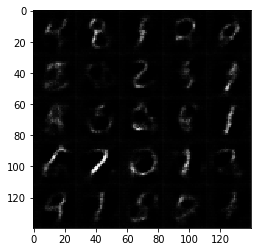

Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 1.2618... Generator Loss: 1.2377
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.6516
Epoch 1/2... Discriminator Loss: 1.1663... Generator Loss: 0.9665
Epoch 1/2... Discriminator Loss: 1.1567... Generator Loss: 0.7835
Epoch 1/2... Discriminator Loss: 1.4964... Generator Loss: 0.5226
Epoch 1/2... Discriminator Loss: 1.1822... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 1.2708... Generator Loss: 0.7473
Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 1.1720
Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 1.1440


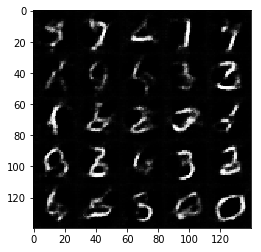

Epoch 1/2... Discriminator Loss: 1.3698... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 1.4465
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 0.8418
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.6171
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.6705
Epoch 1/2... Discriminator Loss: 1.4777... Generator Loss: 0.5676
Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 0.7073
Epoch 1/2... Discriminator Loss: 1.1331... Generator Loss: 0.9883
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 1.1166
Epoch 1/2... Discriminator Loss: 1.0965... Generator Loss: 0.8656


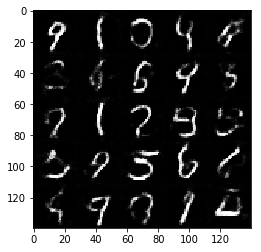

Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 1.2972
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 1.0904
Epoch 1/2... Discriminator Loss: 1.1424... Generator Loss: 0.8308
Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 0.7967
Epoch 1/2... Discriminator Loss: 1.3293... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.2325... Generator Loss: 0.9432
Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 0.8423
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 1.5129
Epoch 1/2... Discriminator Loss: 1.4183... Generator Loss: 0.5826


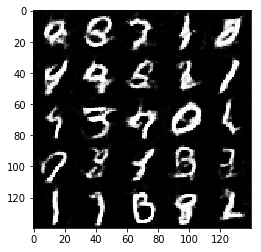

Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 0.9440
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 1.3391
Epoch 1/2... Discriminator Loss: 1.1483... Generator Loss: 1.2207
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 1.4603
Epoch 1/2... Discriminator Loss: 1.1450... Generator Loss: 1.0289
Epoch 1/2... Discriminator Loss: 1.1356... Generator Loss: 1.1445
Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 0.7952
Epoch 1/2... Discriminator Loss: 0.9682... Generator Loss: 1.0613
Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 0.7857
Epoch 1/2... Discriminator Loss: 1.1605... Generator Loss: 0.7455


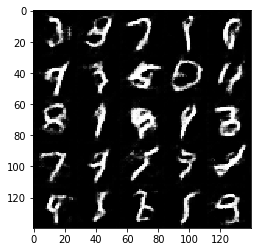

Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 1.5665
Epoch 1/2... Discriminator Loss: 1.1050... Generator Loss: 0.9246
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 1.2339
Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 0.8166
Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 1.4449
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 0.6568
Epoch 1/2... Discriminator Loss: 1.1682... Generator Loss: 0.8677
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 1.1790
Epoch 1/2... Discriminator Loss: 1.4774... Generator Loss: 0.5004


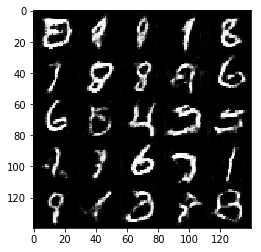

Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 1.6341
Epoch 1/2... Discriminator Loss: 1.1247... Generator Loss: 0.7713
Epoch 1/2... Discriminator Loss: 1.2980... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 1.7261... Generator Loss: 2.0026
Epoch 2/2... Discriminator Loss: 1.2100... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 1.2358... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 0.6614
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 1.2416
Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 0.8676
Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 0.6300


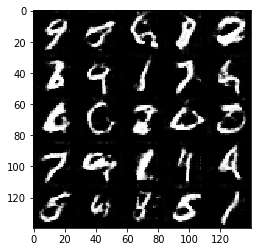

Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 0.8140
Epoch 2/2... Discriminator Loss: 1.4788... Generator Loss: 2.4332
Epoch 2/2... Discriminator Loss: 1.2464... Generator Loss: 0.6998
Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 1.4034
Epoch 2/2... Discriminator Loss: 1.2980... Generator Loss: 0.6514
Epoch 2/2... Discriminator Loss: 1.1607... Generator Loss: 0.9699
Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 1.3232
Epoch 2/2... Discriminator Loss: 1.0522... Generator Loss: 0.9644
Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 0.7569
Epoch 2/2... Discriminator Loss: 1.5222... Generator Loss: 0.5483


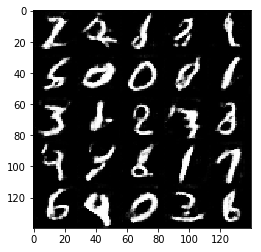

Epoch 2/2... Discriminator Loss: 1.0589... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 1.0774... Generator Loss: 1.0680
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 1.4094
Epoch 2/2... Discriminator Loss: 1.2709... Generator Loss: 0.6902
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 1.6796
Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 0.7290
Epoch 2/2... Discriminator Loss: 1.1530... Generator Loss: 1.2435
Epoch 2/2... Discriminator Loss: 1.0016... Generator Loss: 1.0283
Epoch 2/2... Discriminator Loss: 1.1275... Generator Loss: 1.1542


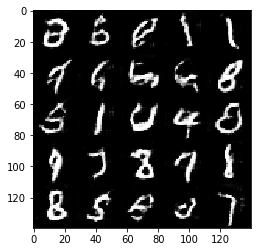

Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 0.7701
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 0.8505
Epoch 2/2... Discriminator Loss: 1.2713... Generator Loss: 0.6520
Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.5188
Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.5770
Epoch 2/2... Discriminator Loss: 1.0414... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 0.9515
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 1.2632
Epoch 2/2... Discriminator Loss: 1.1907... Generator Loss: 0.8032
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 1.3123


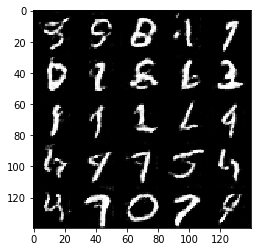

Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 1.0665
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 1.0466
Epoch 2/2... Discriminator Loss: 1.2164... Generator Loss: 0.8617
Epoch 2/2... Discriminator Loss: 1.0991... Generator Loss: 0.9751
Epoch 2/2... Discriminator Loss: 1.2208... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 1.3066... Generator Loss: 0.6284
Epoch 2/2... Discriminator Loss: 1.0603... Generator Loss: 0.8388
Epoch 2/2... Discriminator Loss: 1.2163... Generator Loss: 0.7138
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 0.9064
Epoch 2/2... Discriminator Loss: 1.1564... Generator Loss: 1.0468


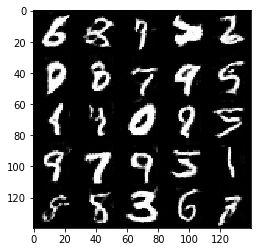

Epoch 2/2... Discriminator Loss: 1.3191... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 1.2538
Epoch 2/2... Discriminator Loss: 1.0156... Generator Loss: 1.1101
Epoch 2/2... Discriminator Loss: 1.0740... Generator Loss: 0.8858
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 1.0308... Generator Loss: 1.6207
Epoch 2/2... Discriminator Loss: 1.2393... Generator Loss: 0.7030
Epoch 2/2... Discriminator Loss: 1.3486... Generator Loss: 1.3601
Epoch 2/2... Discriminator Loss: 1.3277... Generator Loss: 0.6480
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.7582


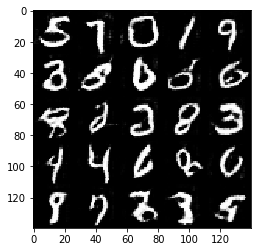

Epoch 2/2... Discriminator Loss: 1.4618... Generator Loss: 0.5852
Epoch 2/2... Discriminator Loss: 1.1764... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 1.1179... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 1.1643... Generator Loss: 0.7676
Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 0.8860
Epoch 2/2... Discriminator Loss: 1.5489... Generator Loss: 0.5301
Epoch 2/2... Discriminator Loss: 1.0690... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 0.9931... Generator Loss: 1.2319
Epoch 2/2... Discriminator Loss: 1.2130... Generator Loss: 1.5353
Epoch 2/2... Discriminator Loss: 1.1402... Generator Loss: 0.8546


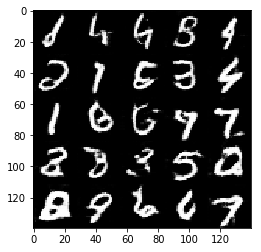

Epoch 2/2... Discriminator Loss: 1.1673... Generator Loss: 0.8493
Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 0.6364
Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 0.9996
Epoch 2/2... Discriminator Loss: 1.0108... Generator Loss: 1.3969
Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 0.8526
Epoch 2/2... Discriminator Loss: 0.9685... Generator Loss: 1.2541
Epoch 2/2... Discriminator Loss: 1.1154... Generator Loss: 0.8595
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.8788
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.7281
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.1506


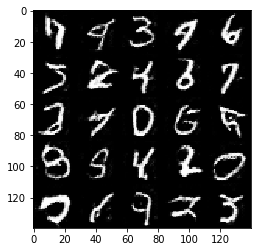

Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 0.8145
Epoch 2/2... Discriminator Loss: 1.1908... Generator Loss: 0.7247
Epoch 2/2... Discriminator Loss: 1.2000... Generator Loss: 0.7618
Epoch 2/2... Discriminator Loss: 1.0602... Generator Loss: 1.0016
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.6563
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 1.4887
Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 1.1174
Epoch 2/2... Discriminator Loss: 1.1423... Generator Loss: 0.7564
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 0.9667
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.7442


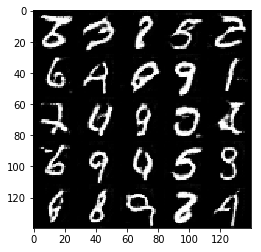

Epoch 2/2... Discriminator Loss: 1.1357... Generator Loss: 0.8976
Epoch 2/2... Discriminator Loss: 1.1550... Generator Loss: 0.7115
Epoch 2/2... Discriminator Loss: 1.1005... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 1.1043... Generator Loss: 0.9585
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 1.0660
Epoch 2/2... Discriminator Loss: 1.0754... Generator Loss: 0.9744
Epoch 2/2... Discriminator Loss: 1.2025... Generator Loss: 0.8955


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.5926
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.5497
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 1.0812
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.9949... Generator Loss: 2.1991
Epoch 1/1... Discriminator Loss: 1.6269... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 1.9638... Generator Loss: 0.4671
Epoch 1/1... Discriminator Loss: 1.7984... Generator Loss: 0.5617


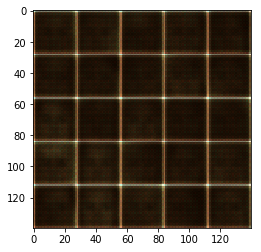

Epoch 1/1... Discriminator Loss: 1.8623... Generator Loss: 2.3198
Epoch 1/1... Discriminator Loss: 1.7710... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.0047
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.9235
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 1.2467
Epoch 1/1... Discriminator Loss: 1.5787... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.8036


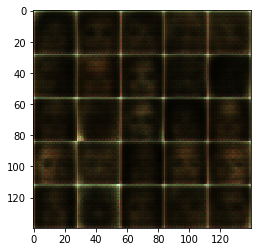

Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 0.8547... Generator Loss: 1.1482
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 1.3339
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 1.8938
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 1.8243... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 3.1704
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7094


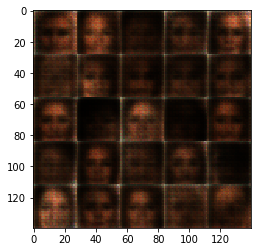

Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.6619... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.6940... Generator Loss: 0.7010


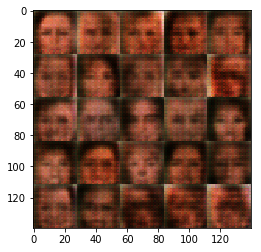

Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7727


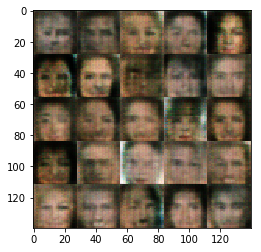

Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7415


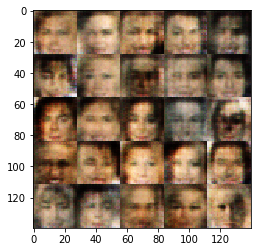

Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.6404... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.8893


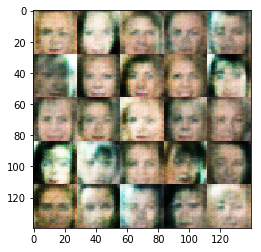

Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.8335


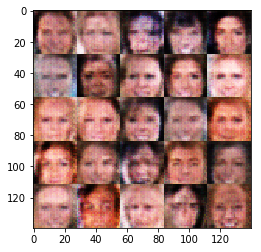

Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8666


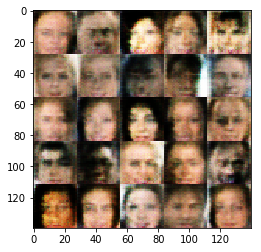

Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.8354


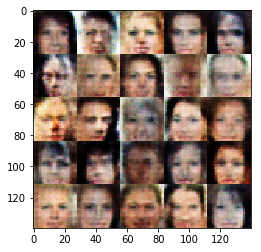

Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7678


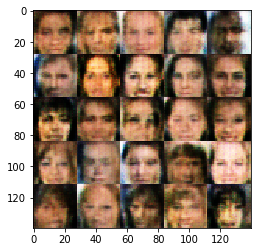

Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8822


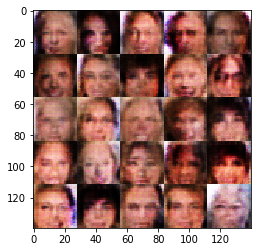

Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 1.6080
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 2.7828
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.7750
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.9126


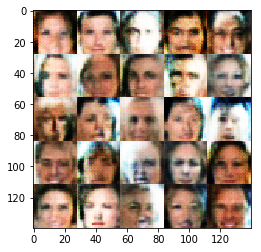

Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 1.5263
Epoch 1/1... Discriminator Loss: 1.7599... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7886


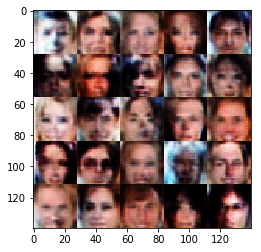

Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 1.3858
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.5792... Generator Loss: 0.6205


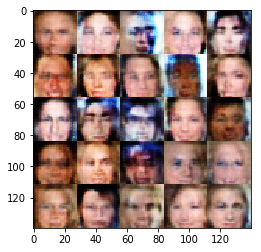

Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.5881
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.9107
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6980


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.